In [1]:
import sys
sys.path.append("..")

import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
import os
from spiralcutter_advanced.libs.spiral_funcs import *
from spiralcutter_advanced.libs.profile_funcs import *
from spiralcutter_advanced.libs.helper_funcs import *
from scipy.optimize import curve_fit
from astropy.io import fits

In [2]:
messier_dict = {
    "NGC 0628": "MESSIER 074",
    "NGC 4254": "MESSIER 099",
    "NGC 4303": "MESSIER 061",
    "NGC 4321": "MESSIER 100",
    "NGC 5236": "MESSIER 083"
}

cr_db = pd.read_csv("../other/corotations.csv")

def find_disc_params(gal, fn):
    path = f"../galaxies_images/{gal}/{fn}"
    disc_found = False
    h = []
    r_br = np.nan
    with open(path, "r") as file:
        for line in file:
            if line.startswith("FUNCTION Exponential") or line.startswith("FUNCTION BrokenExponential"):
                disc_found = True
            if not disc_found:
                continue
            if line.startswith("h"):
                h.append(float(line.split()[1]) * 0.75)
            if line.startswith("r_break"):
                r_br = float(line.split()[1]) * 0.75
    return (h, r_br)

def find_corotations(gal):
    galname = f"{gal[:3]} {gal[3:]}"
    if galname in messier_dict:
        galname = messier_dict[galname]
    cr_list = cr_db.loc[cr_db["Unnamed: 0"] == galname, "cr"].tolist()[0][1:-1]
    cr_arr = []
    for cr in cr_list.split(", "):
        cr_arr.append(float(cr))
    cr_arr = np.array(cr_arr)
    nona = ~np.isnan(cr_arr)
    return(cr_arr[nona])

def find_spiral_h(gal, masked = False, breaks = False):
    path = f"../galaxies_images/{gal}/spiral_params/h_spiral.dat"
    if breaks:
        path = f"../galaxies_images/{gal}/spiral_params/h_spiral_break.dat"
        h = []
        with open(path, "r") as file:
            for line in file:
                h.append(float(line.split()[1]))
        return h
    if masked:
        path = f"../galaxies_images/{gal}/spiral_params/h_spiral_masked.dat"
        if breaks:
            path = f"../galaxies_images/{gal}/spiral_params/h_spiral_break_masked.dat"
            h = []
            with open(path, "r") as file:
                for line in file:
                    h.append(float(line.split()[1]))
            return h
    with open(path, "r") as file:
        for line in file:
            h = float(line.split()[0])
    return h

def find_arms_shapes(gal, funcs_all = False, return_popt = False):
    funcs_list = [sp_o1, sp_o2, sp_o3, sp_o4, sp_o5, sp_o1_br1, sp_o2_br1, sp_o3_br1,
                  sp_o1_br2, sp_o2_br2, arch_sp, arch_sp_o3, hyp_sp, hyp_sp_o3, sp_wave]
    models_list = [exponential, exponential_mg_phi, exp_mg_phi_wd1, exp_mg_phi_wd2]
    path_sh = f"../galaxies_images/{gal}/spiral_params/shapes.dat"
    if funcs_all:
        path_sh = f"../galaxies_images/{gal}/spiral_params/shapes_all.dat"
    path_prof = f"../galaxies_images/{gal}/spiral_params/profiles_1d.dat"
    
    phi_list = []
    r_list = []
    col_list = []
    hs_simple_list = []
    hs_final_list = []
    dips_list_phi = []
    dips_list = []
    popt_list = []
    names_list = []
    
    with open(path_sh, "r") as file:
        for line in file:
            col, fname, phi0, phie = line.split()[0:4]
            phi0 = float(phi0)
            phie = float(phie)
            this_func = None
            for func in funcs_list:
                if func.__name__ == fname:
                    this_func = func
            params = line.split("[")[1].split("]")[0]
            params = np.array(params.split()).astype(float)
            if np.isnan(params[0]):
                continue
            #print(params[0])
            #print(this_func(np.radians(0), *params))
            phi_arr = np.linspace(0, np.radians(np.abs(phie - phi0)), 500)
            r_arr = this_func(phi_arr, *params)
            phi_list.append(phi_arr)
            r_list.append(r_arr)
            col_list.append(col)
            popt_list.append(params)
            names_list.append(fname)
    
    g_i = col_list.index("green")
    if r_list[g_i][0] > r_list[g_i][-1]:
        for i in range(len(col_list)):
            phi_list[i] = np.abs(phi_list[i] - np.max(phi_list[i]))
            phi_list[i] = np.flip(phi_list[i])
            r_list[i] = np.flip(r_list[i])

    with open(path_prof, "r") as file:
        for line in file:
            col, fname = line.split()[0:2]
            this_func = None
            for func in funcs_list:
                if func.__name__ == fname:
                    this_func = func
            params = line.split("[")[1].split("]")[0]
            params = np.array(params.split()).astype(float)
            #print(params[0])
            #print(this_func(np.radians(0), *params))
            h = 1 / params[1]
            if fname == "exponential":
                if len(hs_final_list) < len(hs_simple_list):
                    hs_final_list.append(np.nan)
                    dips_list.append(np.nan)
                    dips_list_phi.append(np.nan)
                hs_simple_list.append(h)
            else:
                hs_final_list.append(h)
                if len(hs_final_list) > len(hs_simple_list):
                    hs_simple_list.append(np.nan)
            
            c_i = col_list.index(col)
            c_r = r_list[c_i]
            c_phi = phi_list[c_i]
            
            if c_phi[0] > c_phi[-1]:
                c_phi = np.flip(c_phi)
                c_r = np.flip(c_r)
            
            if fname == "exp_mg_phi_wd1":
                dips_list.append(np.interp(params[7] - np.radians(30), c_phi, c_r))
                dips_list_phi.append(params[7] - np.radians(30))
            elif fname == "exp_mg_phi_wd2":
                dips_list.append(np.interp(np.array([params[7] - np.radians(30), params[10] - np.radians(30)]), c_phi, c_r))
                dips_list_phi.append([params[7] - np.radians(30), params[10] - np.radians(30)])
            elif fname == "exponential_mg_phi":
                dips_list.append(np.nan)
                dips_list_phi.append(np.nan)
        if len(hs_final_list) < len(hs_simple_list):
            hs_final_list.append(np.nan)
            dips_list.append(np.nan)
            dips_list_phi.append(np.nan)
    
    if return_popt:
        return (col_list, phi_list, r_list, hs_simple_list, hs_final_list, dips_list_phi, dips_list, popt_list, names_list)
    else:
        return (col_list, phi_list, r_list, hs_simple_list, hs_final_list, dips_list_phi, dips_list)
            
    
def lin_0(x, a):
    return a * x

def lin_b(x, a, b):
    return a * x + b

gals = []
gal_paths = glob.glob("../galaxies_images/*")
for path in gal_paths:
    gals.append(path.split("/")[-1])
gals = np.sort(gals)

# disc breaks / spiral breaks / corotations

In [3]:
for gal in gals:
    fig, ax = plt.subplots(figsize=[6, 4])
    
    any_dips = False
    
    h_disc, r_br = find_disc_params(gal, "fit_nosp.imfit")
    crs = find_corotations(gal)
    cols, phis, rs, hss, hfs, dipsphis, dipss = find_arms_shapes(gal)
    
    for cr in crs[1:]:
        ax.axhline(cr, ls = "--", lw = 0.5, c = "k")
    ax.axhline(crs[0], ls = "--", lw = 0.5, c = "k", label = "CRs")
    
    if ~np.isnan(r_br):
        ax.axhline(r_br, ls = ":", lw = 1, c = "r", label = "Disc break")
    
    for i in range(len(cols)):
        col = cols[i]
        phi = phis[i]
        r = rs[i]
        dphi = dipsphis[i]
        dr = dipss[i]
        try:
            if ~np.isnan(dphi):
                any_dips = True
        except ValueError:
            pass
        ax.plot(np.degrees(phi), r, c = col)
        ax.scatter(np.degrees(dphi), dr, c = col)
    ax.plot([], [], c = "k", label = "arm shapes")
    if any_dips:
        ax.scatter(None, None, c = "k", label = "dips in spiral brightness")
    ax.legend()
    ax.set_title(gal)
    ax.set_xlabel("phi, degrees")
    ax.set_ylabel("r, arcsec")
    fig.tight_layout()
    fig.savefig(f"../images/plots/corotation_comp/{gal}", dpi = 300)
    plt.close(fig)

# Different spiral h comp

In [4]:
for gal in gals:
    #print(gal)
    h_disc, r_br = find_disc_params(gal, "fit_nosp.imfit")
    h_spiral = find_spiral_h(gal)
    fig, ax = plt.subplots(figsize=[6, 4])
    cols, phis, rs, hss, hfs, dipsphis, dipss = find_arms_shapes(gal)
    #for i in range(len(cols)):
    #    col = cols[i]
    #    phi = phis[i]
    #    r = rs[i]
    ax.scatter(hss, hfs, c = cols, s = 8, linewidths = 0.5, edgecolors = "k", label = "individual arms")
    if len(h_disc) == 2:
        ax.axvline(h_disc[0], c = "k", lw = 0.5, ls = "--", label = "disc expscales")
        ax.axvline(h_disc[1], c = "k", lw = 0.5, ls = "--")
        h_spiral = find_spiral_h(gal, breaks = True)
        ax.axvline(h_spiral[0], c = "b", lw = 0.5, ls = ":", label = "spiral arms total")
        ax.axvline(h_spiral[1], c = "b", lw = 0.5, ls = ":", alpha = 0.5)
    else:
        ax.axvline(h_disc, c = "k", lw = 0.5, ls = "--", label = "disc expscale")
        ax.axvline(h_spiral, c = "b", lw = 0.5, ls = ":", label = "spiral arms total")
    
    lim_l = np.nanmin([np.nanmin(hss), np.nanmin(hfs), np.nanmin(h_disc), np.nanmin(h_spiral), 1]) - 1
    lim_u = np.nanmax([np.nanmax(hss), np.nanmax(hfs), np.nanmax(h_disc), np.nanmax(h_spiral)]) + 1
    ax.plot([lim_l, lim_u], [lim_l, lim_u], c = "k", lw = 1, label = "1:1")
    ax.set_xlim(lim_l, lim_u)
    ax.set_ylim(lim_l, lim_u)
    
    ax.set_xlabel("h in simple exp fit")
    ax.set_ylabel("h in final fit")
    
    ax.legend()
    fig.tight_layout()
    fig.savefig(f"../images/plots/expscale_comp/{gal}", dpi = 300)
    plt.close(fig)

# Disc vs spiral h comp

NGC3184
NGC4123
NGC5247
[ 64.61745   32.994     95.50725   34.69845   47.515875  82.35225
  31.797975  58.907625  30.154275 125.93775   50.8119    57.1305
  67.22475   43.70085   45.946275  61.316775  67.2549    35.7774
 121.14      30.630975]
[ 88.19  25.79 133.7   20.7   67.5  123.58  29.14  88.71  40.34 178.37
  84.1  145.9   89.3   89.4   47.4   90.7   75.6   45.   113.8   47.6 ]


/tmp/ipykernel_705/3010312500.py:81: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


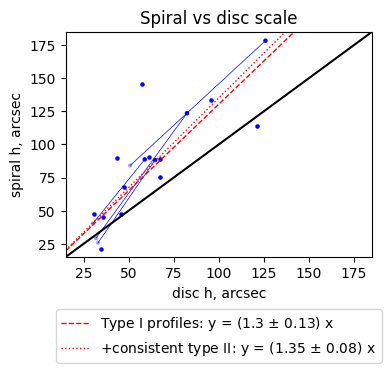

In [5]:
#fig, (ax1, ax2) = plt.subplots(figsize=[8,3], nrows = 1, ncols = 2)
fig, ax1 = plt.subplots(figsize=[4,4], nrows = 1, ncols = 1)

h_all = []
h_sp_all = []
breaks = []

for gal in gals:
    h, r_br = find_disc_params(gal, "fit_nosp.imfit")
    crs = find_corotations(gal)
    h_spiral = find_spiral_h(gal)
    
    if len(h) == 1:
        ax1.scatter(h, h_spiral, s = 5, c = "b")
        h_sp_all.append(h_spiral)
        h_all.extend(h)
        breaks.append(False)
    else:
        h_spiral_br = find_spiral_h(gal, breaks = True)
        if (h_spiral_br[2] / r_br < 0.8) or (h_spiral_br[2] / r_br > 1.2) or (h_spiral_br[1] > h_spiral_br[0]):
            #ax1.scatter(h, h_spiral_br[:2], s = 5, c = "r", alpha = [1, 0.25])
            #ax1.plot(h, h_spiral_br[:2], c = "r", ms = 5, lw = 0.5)
            print(gal)
            continue
        
        ax1.scatter(h, h_spiral_br[:2], s = 5, c = "b", alpha = [1, 0.25])
        ax1.plot(h, h_spiral_br[:2], c = "b", ms = 5, lw = 0.5)
        
        h_sp_all.extend(h_spiral_br[:2])
        h_all.extend(h)
        breaks.extend([True, True])

h_all = np.array(h_all)
h_sp_all = np.array(h_sp_all)
breaks = np.array(breaks)

print(h_all)
print(h_sp_all)

x1 = 15
x2 = 185

ax1.plot([x1, x2], [x1, x2], c = "k")
ax1.set_xlabel("disc h, arcsec")
ax1.set_ylabel("spiral h, arcsec")
ax1.set_title("Spiral vs disc scale")

#ax2.plot([15, 135], [15, 135], c = "k")
#ax2.set_xlabel("disc h, arcsec")
#ax2.set_ylabel("disc h (spirals masked), arcsec")
#ax2.set_title("Disc scale with / without mask")

#ax1.scatter([], [], s = 5, c = "b", label = "Type I and consistent type II")
#ax1.scatter([], [], s = 5, c = "r", label = "Inconsistent type II")

popt, pcov = curve_fit(lin_0, h_all[~breaks], h_sp_all[~breaks])
perr = np.sqrt(np.diag(pcov))
label = f"Type I profiles: y = ({np.round(popt[0], 2)} $\\pm$ {np.round(perr[0], 2)}) x"
ax1.plot(np.array([x1, x2]), lin_0(np.array([x1, x2]), *popt),
        c="r", ls="--", label = label, lw = 1)

popt, pcov = curve_fit(lin_0, h_all, h_sp_all)
perr = np.sqrt(np.diag(pcov))
label = f"+consistent type II: y = ({np.round(popt[0], 2)} $\\pm$ {np.round(perr[0], 2)}) x"
ax1.plot(np.array([x1, x2]), lin_0(np.array([x1, x2]), *popt),
        c="r", ls=":", label = label, lw = 1)

ax1.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.2))
ax1.set_xlim(x1, x2)
ax1.set_ylim(x1, x2)

#popt, pcov = curve_fit(lin_0, h_all, h_m_all)
#perr = np.sqrt(np.diag(pcov))
#label = f"y = ({np.round(popt[0], 2)} $\\pm$ {np.round(perr[0], 2)}) x"
#ax2.plot(np.array([20, 130]), lin_0(np.array([20, 130]), *popt),
#        c="r", ls="--", label = label, lw = 1)
#ax2.legend()

fig.tight_layout()
fig.savefig("../images/selected/spiral_expscales", dpi = 300)
fig.show()

NGC3184
NGC4123
NGC5247
[ 53.979525  39.777075  94.13025   29.680875  46.6137    71.54295
  34.44855   60.769725  32.833425 125.93775   48.126075  68.9229
  39.07335   41.725275  55.751175  68.0724    35.2887   119.0535
  30.9879  ]
[ 88.19  25.79 141.4   56.1   50.1  123.58  29.14  88.71  40.34 178.37
  84.1  121.9  118.9   51.7   92.1   62.    40.5  117.6   46.4 ]


/tmp/ipykernel_705/1147022851.py:83: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


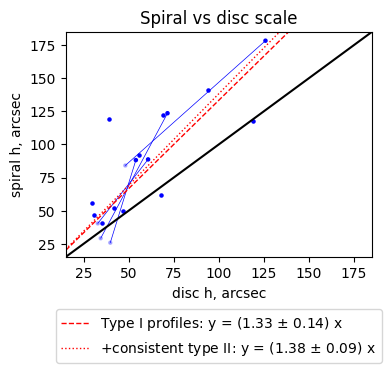

In [6]:
#fig, (ax1, ax2) = plt.subplots(figsize=[8,3], nrows = 1, ncols = 2)
fig, ax1 = plt.subplots(figsize=[4,4], nrows = 1, ncols = 1)

h_all = []
h_sp_all = []
breaks = []

for gal in gals:
    h, r_br = find_disc_params(gal, "masked/fit_masked.imfit")
    crs = find_corotations(gal)
    h_spiral = find_spiral_h(gal, masked = True)
    
    if len(h) == 1:
        if h_spiral > 1000:
            continue
        ax1.scatter(h, h_spiral, s = 5, c = "b")
        h_sp_all.append(h_spiral)
        h_all.extend(h)
        breaks.append(False)
    else:
        h_spiral_br = find_spiral_h(gal, masked = True, breaks = True)
        if (h_spiral_br[2] / r_br < 0.8) or (h_spiral_br[2] / r_br > 1.2) or (h_spiral_br[1] > h_spiral_br[0]):
            #ax1.scatter(h, h_spiral_br[:2], s = 5, c = "r", alpha = [1, 0.25])
            #ax1.plot(h, h_spiral_br[:2], c = "r", ms = 5, lw = 0.5)
            print(gal)
            continue
        
        ax1.scatter(h, h_spiral_br[:2], s = 5, c = "b", alpha = [1, 0.25])
        ax1.plot(h, h_spiral_br[:2], c = "b", ms = 5, lw = 0.5)
        
        h_sp_all.extend(h_spiral_br[:2])
        h_all.extend(h)
        breaks.extend([True, True])

h_all = np.array(h_all)
h_sp_all = np.array(h_sp_all)
breaks = np.array(breaks)

print(h_all)
print(h_sp_all)

x1 = 15
x2 = 185

ax1.plot([x1, x2], [x1, x2], c = "k")
ax1.set_xlabel("disc h, arcsec")
ax1.set_ylabel("spiral h, arcsec")
ax1.set_title("Spiral vs disc scale")

#ax2.plot([15, 135], [15, 135], c = "k")
#ax2.set_xlabel("disc h, arcsec")
#ax2.set_ylabel("disc h (spirals masked), arcsec")
#ax2.set_title("Disc scale with / without mask")

#ax1.scatter([], [], s = 5, c = "b", label = "Type I and consistent type II")
#ax1.scatter([], [], s = 5, c = "r", label = "Inconsistent type II")

popt, pcov = curve_fit(lin_0, h_all[~breaks], h_sp_all[~breaks])
perr = np.sqrt(np.diag(pcov))
label = f"Type I profiles: y = ({np.round(popt[0], 2)} $\\pm$ {np.round(perr[0], 2)}) x"
ax1.plot(np.array([x1, x2]), lin_0(np.array([x1, x2]), *popt),
        c="r", ls="--", label = label, lw = 1)

popt, pcov = curve_fit(lin_0, h_all, h_sp_all)
perr = np.sqrt(np.diag(pcov))
label = f"+consistent type II: y = ({np.round(popt[0], 2)} $\\pm$ {np.round(perr[0], 2)}) x"
ax1.plot(np.array([x1, x2]), lin_0(np.array([x1, x2]), *popt),
        c="r", ls=":", label = label, lw = 1)

ax1.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.2))
ax1.set_xlim(x1, x2)
ax1.set_ylim(x1, x2)

#popt, pcov = curve_fit(lin_0, h_all, h_m_all)
#perr = np.sqrt(np.diag(pcov))
#label = f"y = ({np.round(popt[0], 2)} $\\pm$ {np.round(perr[0], 2)}) x"
#ax2.plot(np.array([20, 130]), lin_0(np.array([20, 130]), *popt),
#        c="r", ls="--", label = label, lw = 1)
#ax2.legend()

fig.tight_layout()
#fig.savefig("../images/selected/spiral_expscales", dpi = 300)
fig.show()

# Pitch angles

0.5681818181818182


/tmp/ipykernel_146689/304100553.py:117: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


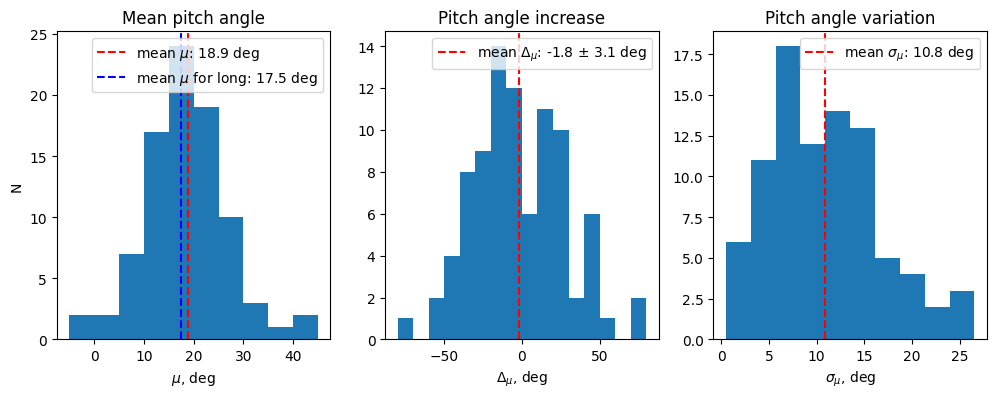

In [5]:
def exp_arm(phi, r0, k1):
    r = r0 * np.exp(phi * k1)
    return r
    
def exp2_arm(phi, r0, k1, k2):
    r = r0 * np.exp(phi * k1 + phi ** 2 * k2)
    return r

#ctr = 0
#ctr_major = 0

mu_avg_all = []
mu_inc_all = []
mu_var_all = []
lengths = []
bends = []

for gal in gals:
    cols, phis, rs, hss, hfs, dipsphis, dipss = find_arms_shapes(gal)
    for i in range(len(cols)):
        phi = phis[i]
        r = rs[i]
        col = cols[i]
        
        mu = np.degrees(np.arctan(np.pad((r[2:] - r[:-2]) / (phi[2:] - phi[:-2]), 1, "edge") / r))
        mu_var = np.std(mu)
        #if (np.nanmax(phi) - np.nanmin(phi)) < np.pi / 2:
        #    continue
        mu_var_all.append(mu_var)
        lengths.append(np.degrees(np.nanmax(phi) - np.nanmin(phi)))
        mu_diff = np.pad(mu[2:] - mu[:-2], 1, "edge")
        bend = np.where(np.abs(mu_diff) > 5)
        
        #if np.degrees(np.max(phi)) > 90:
        #    ctr_major += 1
        
        if len(bend[0]) > 0:
            if len(bend[0]) > 5:
                b1 = bend[0][1]
                b2 = bend[0][-2]
                bend_mag_1 = mu[b1 + 2] - mu[b1 - 2]
                bend_mag_2 = mu[b2 + 2] - mu[b2 - 2]
                bends.append(bend_mag_1)
                bends.append(bend_mag_2)
            else:
                if len(bend[0]) > 2:
                    b = bend[0][1]
                else:
                    b = bend[0][0]
                bend_mag = mu[b + 2] - mu[b - 2]
                bends.append(bend_mag)
        #plt.plot(phi, mu_diff, marker = "o")
        #plt.plot(phi, mu, marker = "o")
        #bend_s = mu[bend + 2] - mu[bend - 2]
        #plt.xlim(phi[bend] - 0.05, phi[bend] + 0.05)
        #plt.show()
        
        p0 = [np.nanmin(r), 0.1]
        sigma = np.sqrt(r)
        popt, pcov = curve_fit(exp_arm, phi, r, p0 = p0, sigma = sigma)
        mu_avg = np.degrees(np.arctan(popt[1]))
        mu_avg_all.append(mu_avg)
        
        p0 = [*popt, 0]
        popt, pcov = curve_fit(exp2_arm, phi, r, p0 = p0, sigma = sigma)
        mu_avg = np.degrees(np.arctan(popt[1]))
        mu_end = np.degrees(np.arctan(popt[1] + 2 * np.nanmax(phi) * popt[2]))
        mu_st = np.degrees(np.arctan(popt[1]))
        mu_inc = mu_end - mu_st
        mu_inc_all.append(mu_inc)
        
#print(ctr_major)
lengths = np.array(lengths)
mu_var_all = np.array(mu_var_all)
mu_avg_all = np.array(mu_avg_all)
mu_inc_all = np.array(mu_inc_all)#[lengths > 180]
bends = np.array(bends)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=[12,4], nrows = 1, ncols = 3)

mean_var = np.mean(mu_var_all)
mean_mu = np.mean(mu_avg_all)
mean_mu_long = np.mean(mu_avg_all[lengths > 180])
mean_inc = np.mean(mu_inc_all)
std_inc = np.std(mu_inc_all) / np.sqrt(len(mu_inc_all))

print(np.sum(mu_inc_all < 0) / len(mu_inc_all))

ax1.hist(mu_avg_all, np.arange(-5, 50, 5), density=False, ec="black", fc="blue")
ax1.axvline(mean_mu, ls = "--", c = "r", label = f"mean $\\mu$: {np.round(mean_mu, 1)} deg")
ax1.axvline(mean_mu_long, ls = "--", c = "b", label = f"mean $\\mu$ for long: {np.round(mean_mu_long, 1)} deg")
ax1.legend()
ax1.set_xlabel("$\\mu$, deg")
ax1.set_ylabel("N")
ax1.set_title("Mean pitch angle")


ax2.hist(mu_inc_all, np.arange(-80, 90, 10), density=False, ec="black", fc="blue")
ax2.axvline(mean_inc, ls = "--", c = "r",
            label = f"mean $\\Delta_\\mu$: {np.round(mean_inc, 1)} $\\pm$ {np.round(std_inc, 1)} deg")
ax2.legend()
ax2.set_xlabel("$\\Delta_\\mu$, deg")
ax2.set_title("Pitch angle increase")

ax3.hist(mu_var_all, density=False, ec="black", fc="blue")
ax3.axvline(mean_var, ls = "--", c = "r",
            label = f"mean $\\sigma_\\mu$: {np.round(mean_var, 1)} deg")
ax3.legend()
ax3.set_xlabel("$\\sigma_\\mu$, deg")
ax3.set_title("Pitch angle variation")

#ax3.hist(bends, density=False, ec="black", fc="blue")
#ax3.legend()
#ax3.set_xlabel("$\\mu_b$, deg")
#ax3.set_title("Bending magnitude")

fig.show()

/tmp/ipykernel_705/1784574674.py:101: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


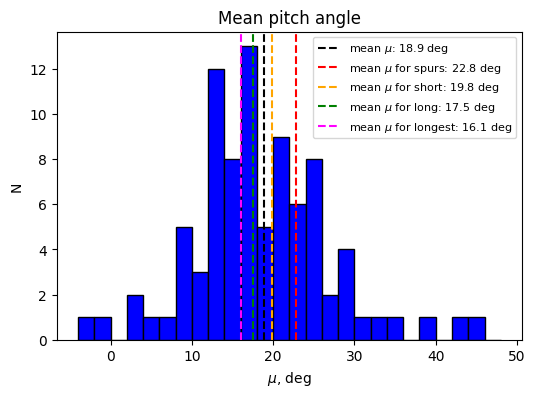

In [13]:
def exp_arm(phi, r0, k1):
    r = r0 * np.exp(phi * k1)
    return r
    
def exp2_arm(phi, r0, k1, k2):
    r = r0 * np.exp(phi * k1 + phi ** 2 * k2)
    return r

#ctr = 0
#ctr_major = 0

mu_avg_all = []
mu_inc_all = []
mu_var_all = []
lengths = []
bends = []

for gal in gals:
    cols, phis, rs, hss, hfs, dipsphis, dipss = find_arms_shapes(gal)
    for i in range(len(cols)):
        phi = phis[i]
        r = rs[i]
        col = cols[i]
        
        mu = np.degrees(np.arctan(np.pad((r[2:] - r[:-2]) / (phi[2:] - phi[:-2]), 1, "edge") / r))
        mu_var = np.std(mu)
        #if (np.nanmax(phi) - np.nanmin(phi)) < np.pi / 2:
        #    continue
        mu_var_all.append(mu_var)
        lengths.append(np.degrees(np.nanmax(phi) - np.nanmin(phi)))
        mu_diff = np.pad(mu[2:] - mu[:-2], 1, "edge")
        bend = np.where(np.abs(mu_diff) > 5)
        
        #if np.degrees(np.max(phi)) > 90:
        #    ctr_major += 1
        
        if len(bend[0]) > 0:
            if len(bend[0]) > 5:
                b1 = bend[0][1]
                b2 = bend[0][-2]
                bend_mag_1 = mu[b1 + 2] - mu[b1 - 2]
                bend_mag_2 = mu[b2 + 2] - mu[b2 - 2]
                bends.append(bend_mag_1)
                bends.append(bend_mag_2)
            else:
                if len(bend[0]) > 2:
                    b = bend[0][1]
                else:
                    b = bend[0][0]
                bend_mag = mu[b + 2] - mu[b - 2]
                bends.append(bend_mag)
        #plt.plot(phi, mu_diff, marker = "o")
        #plt.plot(phi, mu, marker = "o")
        #bend_s = mu[bend + 2] - mu[bend - 2]
        #plt.xlim(phi[bend] - 0.05, phi[bend] + 0.05)
        #plt.show()
        
        p0 = [np.nanmin(r), 0.1]
        sigma = np.sqrt(r)
        popt, pcov = curve_fit(exp_arm, phi, r, p0 = p0, sigma = sigma)
        mu_avg = np.degrees(np.arctan(popt[1]))
        mu_avg_all.append(mu_avg)
        
        p0 = [*popt, 0]
        popt, pcov = curve_fit(exp2_arm, phi, r, p0 = p0, sigma = sigma)
        mu_avg = np.degrees(np.arctan(popt[1]))
        mu_end = np.degrees(np.arctan(popt[1] + 2 * np.nanmax(phi) * popt[2]))
        mu_st = np.degrees(np.arctan(popt[1]))
        mu_inc = mu_end - mu_st
        mu_inc_all.append(mu_inc)
        
#print(ctr_major)
lengths = np.array(lengths)
mu_var_all = np.array(mu_var_all)
mu_avg_all = np.array(mu_avg_all)
mu_inc_all = np.array(mu_inc_all)#[lengths > 180]
bends = np.array(bends)

fig, ax = plt.subplots(figsize=[6,4])

mean_var = np.mean(mu_var_all)
mean_mu = np.mean(mu_avg_all)
mean_mu_spurs = np.mean(mu_avg_all[lengths < 90])
mean_mu_short = np.mean(mu_avg_all[lengths < 180])
mean_mu_long = np.mean(mu_avg_all[lengths > 180])
mean_mu_longest = np.mean(mu_avg_all[lengths > 360])
mean_inc = np.mean(mu_inc_all)
std_inc = np.std(mu_inc_all) / np.sqrt(len(mu_inc_all))

ax.hist(mu_avg_all, np.arange(-4, 50, 2), density=False, edgecolor="black", facecolor="blue")
ax.axvline(mean_mu, ls = "--", c = "k", label = f"mean $\\mu$: {np.round(mean_mu, 1)} deg")
ax.axvline(mean_mu_spurs, ls = "--", c = "red", label = f"mean $\\mu$ for spurs: {np.round(mean_mu_spurs, 1)} deg")
ax.axvline(mean_mu_short, ls = "--", c = "orange", label = f"mean $\\mu$ for short: {np.round(mean_mu_short, 1)} deg")
ax.axvline(mean_mu_long, ls = "--", c = "green", label = f"mean $\\mu$ for long: {np.round(mean_mu_long, 1)} deg")
ax.axvline(mean_mu_longest, ls = "--", c = "magenta", label = f"mean $\\mu$ for longest: {np.round(mean_mu_longest, 1)} deg")
ax.legend(fontsize=8)
ax.set_xlabel("$\\mu$, deg")
ax.set_ylabel("N")
ax.set_title("Mean pitch angle")

fig.show()